# IBM Applied Data Science Capstone: "Living in Milano"

This Jupyter Notebook is for the capstone project of IBM's Data Science Professional Certificate by Coursera.

## Install and import relevant libraries

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium
import geocoder # to get coordinates
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import requests # library to handle requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd # library for data analsysis
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
from bs4 import BeautifulSoup # library to parse HTML and XML documents
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
print("Libraries imported!")

Libraries imported!


## Scrape Wikipedia pages for districts and Metro stations in Milano

In [2]:
districts=requests.get("https://en.wikipedia.org/wiki/Category:Districts_of_Milan").text
soupdistr=BeautifulSoup(districts,'html.parser') 
#districts

In [3]:
metrostat=requests.get("https://en.wikipedia.org/wiki/Category:Milan_Metro_stations").text
soupmetro=BeautifulSoup(metrostat,'html.parser')
#metrostat

### Create a (clean) dataframe for Milano's districts

In [4]:
districtlist=[]
for row in soupdistr.find_all("div",class_="mw-category")[0].findAll("li"):
    districtlist.append(row.text)
dfD=pd.DataFrame({"District": districtlist})
dfD['District']=dfD['District'].str.replace(' \(district of Milan\)','')
dfD['District']=dfD['District'].str.replace(' \(district\)','')
dfD['District']=dfD['District'].str.replace(' \(Milan\)','')
dfD['District']=dfD['District'].str.replace(', Milan','')
dfD['District']=dfD['District'].str.replace(' di Milano','')
dfD['District']=dfD['District'].str.replace('Milano ','')
dfD['District']=dfD['District'].str.replace('Quartiere ','')
dfD['District']=dfD['District'].str.replace('moda','Moda')
dfD['District']=dfD['District'].str.replace('-Lorenteggio','')
dfD=dfD.append({'District': 'Lorenteggio'},ignore_index=True)
dfD=dfD.sort_values('District',ascending=True)
dfD=dfD.reset_index(drop=True)
#dfD.to_csv('Milano_districts.csv')
print('Districts:',dfD.shape)
dfD.head()

Districts: (77, 1)


,District
0,Affori
1,Assiano
2,Baggio
3,Barona
4,Bicocca


### Create a (clean) dataframe for Milano's Metro stations

In [5]:
metrolist=[]
for row in soupmetro.find_all("div",class_="mw-category")[0].findAll("li"):
    metrolist.append(row.text)
dfM=pd.DataFrame({"Station": metrolist})
dfM['Station']=dfM['Station'].str.replace(' \(Milan Metro\)','')
dfM=dfM.sort_values('Station',ascending=True)
dfM=dfM.reset_index(drop=True)
#dfM.to_csv('Milano_metros.csv')
print('MM Stations:',dfM.shape)
dfM.head()

MM Stations: (106, 1)


,Station
0,Abbiategrasso
1,Affori Centro
2,Affori FN
3,Amendola
4,Assago Milanofiori Forum


## Load information about Milano's boroughs (ID#, surface [km^2], population)

In [6]:
dfB=pd.ExcelFile('Milano_rawebdata.xlsx').parse('boroughs')
dfB

,Borough,Surface,Population
0,1,9.67,97403
1,2,12.58,159134
2,3,14.23,142939
3,4,20.95,15975
4,5,29.87,124903
5,6,18.28,150356
6,7,31.34,173643
7,8,23.72,186179
8,9,21.12,186566


## Load databases of average houses price [€/m^2] in Milano's zones

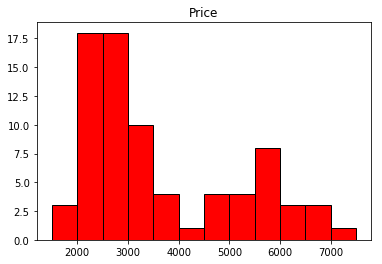

Zones: (77, 3)


,District,Price,Range
0,Adriano,2600,lower
1,Affori,2250,lower
2,Baggio,2250,lower
3,Barona,2900,lower
4,Bicocca,2600,lower


In [7]:
dfZ=pd.ExcelFile('Milano_rawebdata.xlsx').parse('zones')
dfZ.rename(columns={'Zone':'District'},inplace=True)
dfZ.hist(column='Price',bins=np.linspace(1500,7500,13),grid=False,ec="k",color='r',stacked=False,density=False)
plt.show() #np.histogram(dfZ.Price,bins=bins,density=False)
dfZ['Range']=dfZ['Price'].apply(lambda x: 'lower' if (x<4000) else 'upper')
print('Zones:',dfZ.shape)
dfZ.head()

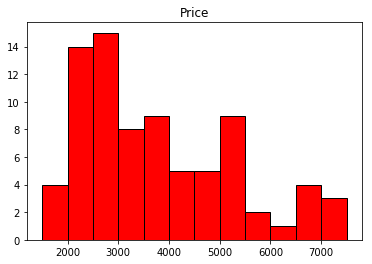

Metro: (86, 5)


,Station,Line,Borough,Price,Range
0,Cairoli,1,1,7970,upper
1,Conciliazione,1,1,6950,upper
2,Cordusio,1,1,8100,upper
3,Palestro,1,1,7310,upper
4,Porta Venezia,1,1,5270,upper


In [8]:
dfS=pd.ExcelFile('Milano_rawebdata.xlsx').parse('stations')
dfS.hist(column='Price',bins=np.linspace(1500,7500,13),grid=False,ec="k",color='r',stacked=False,density=False)
plt.show() #np.histogram(dfZ.Price,bins=bins,density=False)
dfS['Range']=dfS['Price'].apply(lambda x: 'lower' if (x<4000) else 'upper')
print('Metro:',dfS.shape)
dfS.head()

### Merge with Milano's districts dataframe

In [9]:
dfDZ=pd.merge(dfD,dfZ,on='District',how='left').dropna()
dfDZ['Price']=dfDZ['Price'].values.astype(int)
dfDZ=dfDZ.sort_values('District',ascending=True)
dfDZ=dfDZ.reset_index(drop=True)
print('Districts:',dfDZ.shape)
dfDZ.head()

Districts: (51, 3)


,District,Price,Range
0,Affori,2250,lower
1,Baggio,2250,lower
2,Barona,2900,lower
3,Bicocca,2600,lower
4,Bovisa,2350,lower


### Merge with Milano's Metro stations dataframe

In [10]:
dfMS=pd.merge(dfM,dfS,on='Station',how='left').dropna()
dfMS['Price']=dfMS['Price'].values.astype(int)
dfMS['Borough']=dfMS['Borough'].values.astype(int)
dfMS=dfMS.sort_values(by=['Borough','Line'])
dfMS=dfMS.reset_index(drop=True)
print('Metro:',dfMS.shape)
dfMS.head()

Metro: (78, 5)


,Station,Line,Borough,Price,Range
0,Cairoli,1,1,7970,upper
1,Conciliazione,1,1,6950,upper
2,Cordusio,1,1,8100,upper
3,Palestro,1,1,7310,upper
4,Porta Venezia,1,1,5270,upper


## Get the geographical coordinates of Milano's districts and Metro stations

In [11]:
def get_latlon(place):
    latlon_coords=None
    while(latlon_coords is None):
        g=geocoder.arcgis('{}, Milano, Italia'.format(place))
        latlon_coords=g.latlng
    return latlon_coords

In [12]:
coordsD=[get_latlon(place) for place in dfDZ["District"].tolist()]
dfDC=pd.DataFrame(coordsD,columns=['Latitude','Longitude'])
#dfDC.to_csv('District_coordinates.csv',index=False)
print('District Geolocation:',dfDC.shape)
dfDC.head()

District Geolocation: (51, 2)


,Latitude,Longitude
0,45.51410,9.17353
1,45.46324,9.09270
2,45.43371,9.15160
3,45.52149,9.21326
4,45.50313,9.16122


In [13]:
coordsM=[get_latlon(place) for place in dfMS["Station"].tolist()]
dfMC=pd.DataFrame(coordsM,columns=['Latitude','Longitude'])
#dfMC.to_csv('Metro_coordinates.csv',index=False)
print('Metro Geolocation:',dfMC.shape)
dfMC.head()

Metro Geolocation: (78, 2)


,Latitude,Longitude
0,45.525371,9.523176
1,45.467230,9.166120
2,45.465043,9.186025
3,45.444489,8.896729
4,45.470980,9.199810


### Add to Milano's districts dataframe

In [14]:
dfDZ['Latitude']=dfDC['Latitude']
dfDZ['Longitude']=dfDC['Longitude']
#dfDZ.to_csv('Milano_DZ.csv')
print('District:',dfDZ.shape)
dfDZ.head()

District: (51, 5)


,District,Price,Range,Latitude,Longitude
0,Affori,2250,lower,45.51410,9.17353
1,Baggio,2250,lower,45.46324,9.09270
2,Barona,2900,lower,45.43371,9.15160
3,Bicocca,2600,lower,45.52149,9.21326
4,Bovisa,2350,lower,45.50313,9.16122


### Add to Milano's Metro stations dataframe

In [15]:
#dfMC=pd.read_csv('metros_geo.csv') #file di servizio!
dfMS['Latitude']=dfMC['Latitude']
dfMS['Longitude']=dfMC['Longitude']
#dfMS.to_csv('Milano_MS.csv')
print('Metro:',dfMS.shape)
dfMS.head()

Metro: (78, 7)


,Station,Line,Borough,Price,Range,Latitude,Longitude
0,Cairoli,1,1,7970,upper,45.525371,9.523176
1,Conciliazione,1,1,6950,upper,45.467230,9.166120
2,Cordusio,1,1,8100,upper,45.465043,9.186025
3,Palestro,1,1,7310,upper,45.444489,8.896729
4,Porta Venezia,1,1,5270,upper,45.470980,9.199810


## Load and refine consolidated dataframe of Milano's districts and Metro stations

In [16]:
cdfB=pd.ExcelFile('Milano_dataframe.xlsx').parse('boroughs')
cdfD=pd.ExcelFile('Milano_dataframe.xlsx').parse('districts')
cdfM=pd.ExcelFile('Milano_dataframe.xlsx').parse('metros')

In [17]:
cdfB['Price']=np.asarray(cdfM.groupby(['Borough'])['Price'].mean().astype(int))
cdfB['Range']=cdfB['Price'].apply(lambda x: 'lower' if (x<4000) else 'upper')
cdfB

,Borough,Surface,Population,Price,Range
0,1,9.67,97403,7044,upper
1,2,12.58,159134,3084,lower
2,3,14.23,142939,3077,lower
3,4,20.95,15975,2697,lower
4,5,29.87,124903,2560,lower
5,6,18.28,150356,3241,lower
6,7,31.34,173643,4326,upper
7,8,23.72,186179,3687,lower
8,9,21.12,186566,3168,lower


### Focus on Milano's districts and Metro stations within the city's outer ring

In [18]:
cdfD=cdfD[cdfD.Latitude>45.38].reset_index(drop=True)
cdfD=cdfD[cdfD.Latitude<45.55].reset_index(drop=True)
cdfD=cdfD[cdfD.Longitude>9.06].reset_index(drop=True)
cdfD=cdfD[cdfD.Longitude<9.27].reset_index(drop=True)
print('District:',cdfD.shape)
cdfD.head()

District: (77, 5)


,District,Price,Range,Latitude,Longitude
0,Adriano,2600,lower,45.514684,9.245257
1,Affori,2250,lower,45.516972,9.169389
2,Baggio,2250,lower,45.460108,9.094160
3,Barona,2900,lower,45.436325,9.154339
4,Bicocca,2600,lower,45.515597,9.210627


In [19]:
cdfM=cdfM[cdfM.Latitude>45.38].reset_index(drop=True)
cdfM=cdfM[cdfM.Latitude<45.55].reset_index(drop=True)
cdfM=cdfM[cdfM.Longitude>9.06].reset_index(drop=True)
cdfM=cdfM[cdfM.Longitude<9.27].reset_index(drop=True)
print('Metro:',cdfM.shape)
cdfM.head()

Metro: (86, 7)


,Station,Line,Borough,Price,Range,Latitude,Longitude
0,Cairoli,1,1,7970,upper,45.468508,9.182230
1,Conciliazione,1,1,6950,upper,45.467686,9.166304
2,Cordusio,1,1,8100,upper,45.465675,9.186362
3,Palestro,1,1,7310,upper,45.471644,9.201917
4,Porta Venezia,1,1,5270,upper,45.475052,9.205523


## Create a map of Milano with districts and Metro stations superimposed

In [163]:
geolocator=Nominatim(user_agent='my_app')
location=geolocator.geocode('Milano, Italia')
latitude=location.latitude
longitude=location.longitude
print('The geographical coordinates of Milano are: {} latitude, {} longitude.'.format(latitude,longitude))

The geographical coordinates of Milano are: 45.4667971 latitude, 9.1904984 longitude.


In [21]:
mapDM=folium.Map(location=[latitude,longitude],zoom_start=10)
for lat, lon, place, cost, borough in zip(cdfM['Latitude'],cdfM['Longitude'],cdfM['Station'],cdfM['Range'],cdfM['Borough']):
    label='{} ({}), #{}'.format(place,cost,borough)
    label=folium.Popup(label,parse_html=True)
    folium.RegularPolygonMarker([lat,lon],number_of_sides=4,rotation=0,radius=3,popup=label,color='red',fill_color='#3186cc',fill_opacity=0.7).add_to(mapDM)   
for lat, lon, place, cost in zip(cdfD['Latitude'],cdfD['Longitude'],cdfD['District'],cdfD['Range']):
    label='{} ({})'.format(place,cost)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lon],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7).add_to(mapDM)   
#mapDM.save('Milano_mapDM.html')
mapDM

## Use Foursquare API to explore Milano's districts

In [22]:
CLIENT_ID='your Foursquare ID'
CLIENT_SECRET='your Foursquare Secret'
VERSION='20180605'
print('CLIENT_ID:',CLIENT_ID)
print('CLIENT_SECRET:',CLIENT_SECRET)
print('Version:',VERSION)

CLIENT_ID: your Foursquare ID
CLIENT_SECRET: your Foursquare Secret
Version: 20180605


### Get a dataframe of the top 100 venues per district that are within a radius of 500m

In [57]:
radius=500; LIMIT=100; venues=[]
for lat, lon, place in zip(cdfD['Latitude'],cdfD['Longitude'],cdfD['District']):
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}' \
        .format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lon,radius,LIMIT)   
    results=requests.get(url).json()['response']['groups'][0]['items']    
    for venue in results:
        venues.append((place,venue['venue']['name'],venue['venue']['categories'][0]['name'],
            venue['venue']['location']['lat'],venue['venue']['location']['lng']))
cdfV=pd.DataFrame(venues)
cdfV.columns=['District','Venue','Category','Latitude','Longitude']
cdfV.to_csv('Milano_venues.csv')
print('There are {} venues of {} categories.'.format(cdfV.shape[0],len(cdfV['Category'].unique())))
cdfV.head()

There are 2573 venues of 254 categories.


,District,Venue,Category,Latitude,Longitude
0,Adriano,Esselunga,Supermarket,45.514053,9.244099
1,Adriano,Parco Adriano (quello Nuovo) Franca Rame,Park,45.517098,9.241924
2,Adriano,Unieuro,Electronics Store,45.514146,9.244038
3,Adriano,df sport specialist,Sporting Goods Shop,45.514412,9.244326
4,Adriano,Esselunga,Supermarket,45.513782,9.244425


### Check how many venues were returned per district

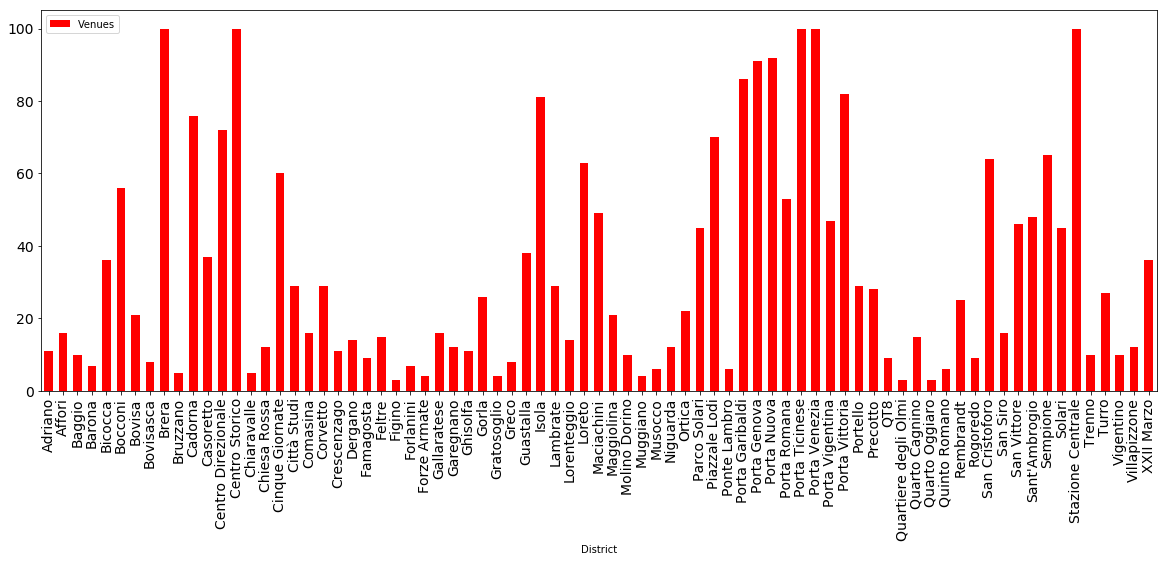

In [208]:
venues=cdfD.copy(); venues=venues.drop(columns=['Price','Range','Latitude','Longitude'])
venues['Venues']=np.asarray(cdfV.groupby(['District'])['Venue'].count())
venues.set_index("District",inplace=True)
venuebar=venues.plot(kind='bar',figsize=(20,7),width=0.6,color='red')
venuebar.tick_params(labelsize=14)
plt.show()

### Analyze the venues per district using one hot encoding 

In [25]:
Milano_ohe=pd.get_dummies(cdfV[['Category']],prefix='',prefix_sep='')
Milano_ohe['District']=cdfV['District']
Milano_ohe=Milano_ohe[list(Milano_ohe.columns[-1:])+list(Milano_ohe.columns[:-1])]
print('Venues:',Milano_ohe.shape)
Milano_ohe.head()

Venues: (2573, 255)


,District,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campanian Restaurant,Campground,Canal,Candy Store,Caribbean Restaurant,Castle,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Quad,Comedy Club,Comic Shop,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Electronics Store,Emilia Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Light Rail Station,Lingerie Store,Locksmith,Lombard Restaurant,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piadineria,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Puglia Restaurant,Radio Station,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roman Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sardinian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Sicilian Restaurant,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,South Tyrolean Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Adriano,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Get the mean frequency of occurrence of each venue category per district

In [26]:
Milano_area=Milano_ohe.groupby(['District']).mean().reset_index()
print('Districts:',Milano_area.shape)
Milano_area.head()

Districts: (77, 255)


,District,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campanian Restaurant,Campground,Canal,Candy Store,Caribbean Restaurant,Castle,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Quad,Comedy Club,Comic Shop,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Electronics Store,Emilia Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Light Rail Station,Lingerie Store,Locksmith,Lombard Restaurant,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piadineria,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Puglia Restaurant,Radio Station,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roman Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sardinian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Sicilian Restaurant,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,South Tyrolean Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Adriano,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

### Get the 5 most common venues per district

In [27]:
num_top_venues=5; indicators=['st','nd','rd']
areaColumns=['District']; freqColumns=[]
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Venue'.format(ind+1,indicators[ind]))
    except:
        freqColumns.append('{}th Venue'.format(ind+1))
area_venues_sorted=pd.DataFrame(columns=areaColumns+freqColumns)
area_venues_sorted['District']=Milano_area['District']
for ind in np.arange(Milano_area.shape[0]):
    row_categories=Milano_area.iloc[ind,1:].iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    area_venues_sorted.iloc[ind,1:]=row_categories_sorted.index.values[0:num_top_venues]
#area_venues_sorted.sort_values(freqColumns,inplace=True)
print('Districts:',area_venues_sorted.shape)
area_venues_sorted.head()

Districts: (77, 6)


,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
0,Adriano,Supermarket,Park,Soccer Field,Electronics Store,Bistro
1,Affori,Italian Restaurant,Café,Pizza Place,Cocktail Bar,Park
2,Baggio,Pizza Place,Café,Japanese Restaurant,Bar,Supermarket
3,Barona,Japanese Restaurant,Trattoria/Osteria,Soccer Field,Café,Filipino Restaurant
4,Bicocca,Café,Sushi Restaurant,Pizza Place,Italian Restaurant,Platform


## Group (using k-means algorithm) Milano's districts into 10 clusters per venue category

In [94]:
kclusters=10
area_clusters=Milano_area.drop(['District'],1)
kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(area_clusters)
area_clustered=cdfD.copy()
area_clustered['Cluster']=kmeans.labels_+1
area_clustered=area_clustered.join(area_venues_sorted.set_index('District'),on='District')
area_clustered.sort_values(['Cluster'],inplace=True)
#area_clustered.to_csv('Milano_clusters.csv')
print('Districts:',area_clustered.shape)
area_clustered

Districts: (77, 11)


,District,Price,Range,Latitude,Longitude,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
26,Forze Armate,2550,lower,45.460494,9.115646,1,Pizza Place,Bakery,Supermarket,Fish Market,Falafel Restaurant
19,Corvetto,2750,lower,45.440427,9.223919,1,Pizza Place,Gym / Fitness Center,Café,Italian Restaurant,Food Truck
2,Baggio,2250,lower,45.460108,9.094160,1,Pizza Place,Café,Japanese Restaurant,Bar,Supermarket
43,Niguarda,2400,lower,45.516246,9.194247,1,Pizza Place,Café,Beer Bar,Pub,Hotel
72,Trenno,2850,lower,45.491642,9.101115,1,Pizza Place,Adult Education Center,Pub,Park,Bakery
9,Bruzzano,2050,lower,45.528577,9.173414,1,Bakery,Italian Restaurant,Gym / Fitness Center,Train Station,Pizza Place
18,Comasina,2000,lower,45.526606,9.161230,2,Bus Station,Café,Fast Food Restaurant,Recreation Center,Pizza Place
36,Lorenteggio,2900,lower,45.443058,9.129247,2,Italian Restaurant,Electronics Store,Noodle House,Café,Supermarket
15,Chiesa Rossa,2650,lower,45.427379,9.174104,2,Park,Mediterranean Restaurant,Light Rail Station,Theater,Bus Station
22,Famagosta,3150,lower,45.437757,9.168691,2,Pharmacy,Playground,Soccer Field,Pizza Place,Shipping Store


### Create a map of Milano with all clusters superimposed

In [95]:
map_clusters=folium.Map(location=[latitude,longitude],zoom_start=11)
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]
markers_colors=[]
for lat, lon, place, cost, borough in zip(cdfM['Latitude'],cdfM['Longitude'],cdfM['Station'],cdfM['Range'],cdfM['Borough']):
    label='{} ({}), borough #{}'.format(place,cost,borough)
    label=folium.Popup(label,parse_html=True)
    folium.RegularPolygonMarker([lat,lon],number_of_sides=4,rotation=0,radius=3,popup=label,color='red',fill_color='#3186cc',fill_opacity=0.7).add_to(map_clusters)
for lat, lon, place, cost, cluster in zip(area_clustered['Latitude'],area_clustered['Longitude'],area_clustered['District'],area_clustered['Range'],area_clustered['Cluster']):
    label = folium.Popup('{} ({}): cluster #{}'.format(place,cost,cluster),parse_html=True)
    folium.CircleMarker([lat,lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
#map_clusters.save('Milano_clusters.html')
map_clusters

### Clusters overview

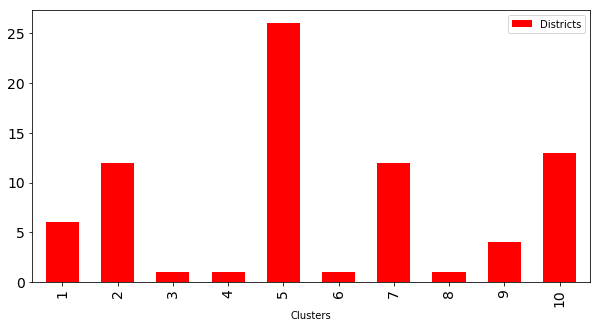

In [209]:
clustfreqs=area_clustered.groupby(['Cluster'])['District'].count()
clusters['Districts']=clustfreqs
clusters['Clusters']=np.linspace(1,kclusters,kclusters).astype(int)
clusters.set_index("Clusters",inplace=True)
clustbar=clusters.plot(kind='bar',figsize=(10,5),width=0.6,color='red')
clustbar.tick_params(labelsize=14)
plt.show()

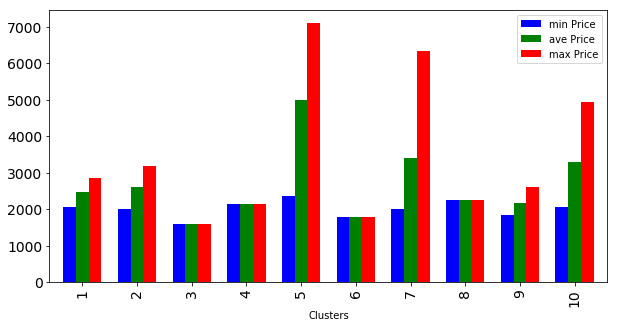

In [211]:
clustprice=area_clustered.groupby(['Cluster'])['Price'].mean().astype(int)
clustahp['min Price']=area_clustered.groupby(['Cluster'])['Price'].min().astype(int)
clustahp['ave Price']=clustprice
clustahp['max Price']=area_clustered.groupby(['Cluster'])['Price'].max().astype(int)
clustahp['Clusters']=np.linspace(1,kclusters,kclusters).astype(int)
clustahp.set_index("Clusters",inplace=True)
clustbar=clustahp.plot(kind='bar',figsize=(10,5),width=0.7,color=['blue','green','red'])
clustbar.tick_params(labelsize=14)
plt.show()

### Cluster 1

In [113]:
clust=area_clustered.loc[area_clustered['Cluster']==1,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[1],'[€/m^2]')
clust

Cluster: 6 districts
Average Houses Price: 2475 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
26,Forze Armate,2550,lower,1,Pizza Place,Bakery,Supermarket,Fish Market,Falafel Restaurant
19,Corvetto,2750,lower,1,Pizza Place,Gym / Fitness Center,Café,Italian Restaurant,Food Truck
2,Baggio,2250,lower,1,Pizza Place,Café,Japanese Restaurant,Bar,Supermarket
43,Niguarda,2400,lower,1,Pizza Place,Café,Beer Bar,Pub,Hotel
72,Trenno,2850,lower,1,Pizza Place,Adult Education Center,Pub,Park,Bakery
9,Bruzzano,2050,lower,1,Bakery,Italian Restaurant,Gym / Fitness Center,Train Station,Pizza Place


### Cluster 2

In [114]:
clust=area_clustered.loc[area_clustered['Cluster']==2,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[2],'[€/m^2]')
clust

Cluster: 12 districts
Average Houses Price: 2616 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
18,Comasina,2000,lower,2,Bus Station,Café,Fast Food Restaurant,Recreation Center,Pizza Place
36,Lorenteggio,2900,lower,2,Italian Restaurant,Electronics Store,Noodle House,Café,Supermarket
15,Chiesa Rossa,2650,lower,2,Park,Mediterranean Restaurant,Light Rail Station,Theater,Bus Station
22,Famagosta,3150,lower,2,Pharmacy,Playground,Soccer Field,Pizza Place,Shipping Store
40,Molino Dorino,2500,lower,2,Bus Station,Italian Restaurant,Sake Bar,Bar,Noodle House
21,Dergano,2500,lower,2,Pizza Place,Peruvian Restaurant,Japanese Restaurant,Ice Cream Shop,Performing Arts Venue
27,Gallaratese,2250,lower,2,Italian Restaurant,Nightclub,Pet Store,Department Store,Mexican Restaurant
28,Garegnano,2150,lower,2,Gym,Pet Store,Diner,Café,Fast Food Restaurant
29,Ghisolfa,2900,lower,2,Breakfast Spot,Shopping Mall,Italian Restaurant,Trattoria/Osteria,Chinese Restaurant
75,Villapizzone,2300,lower,2,Electronics Store,Supermarket,Spa,Ice Cream Shop,Hotel


### Cluster 3

In [115]:
clust=area_clustered.loc[area_clustered['Cluster']==3,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[3],'[€/m^2]')
clust

Cluster: 1 districts
Average Houses Price: 1600 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
61,Quarto Oggiaro,1600,lower,3,Karaoke Bar,Bar,Park,Yoga Studio,Fish Market


### Cluster 4

In [116]:
clust=area_clustered.loc[area_clustered['Cluster']==4,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[4],'[€/m^2]')
clust

Cluster: 1 districts
Average Houses Price: 2150 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
24,Figino,2150,lower,4,Bakery,Stadium,Volleyball Court,Fish Market,Falafel Restaurant


### Cluster 5

In [117]:
clust=area_clustered.loc[area_clustered['Cluster']==5,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[5],'[€/m^2]')
clust

Cluster: 26 districts
Average Houses Price: 5003 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
37,Loreto,3800,lower,5,Hotel,Italian Restaurant,Ice Cream Shop,Chinese Restaurant,Nightclub
32,Greco,2750,lower,5,Pizza Place,Plaza,Steakhouse,Pet Store,Cocktail Bar
45,Parco Solari,5650,upper,5,Italian Restaurant,Pizza Place,Café,Burger Joint,Japanese Restaurant
48,Porta Garibaldi,5500,upper,5,Italian Restaurant,Pizza Place,Hotel,Café,Restaurant
49,Porta Genova,5600,upper,5,Italian Restaurant,Cocktail Bar,Café,Ice Cream Shop,Seafood Restaurant
50,Porta Nuova,6050,upper,5,Italian Restaurant,Café,Restaurant,Hotel,Plaza
51,Porta Romana,5150,upper,5,Italian Restaurant,Wine Bar,Cocktail Bar,Restaurant,Bookstore
52,Porta Ticinese,5550,upper,5,Italian Restaurant,Cocktail Bar,Ice Cream Shop,Café,Vegetarian / Vegan Restaurant
53,Porta Venezia,5950,upper,5,Italian Restaurant,Hotel,Café,Art Gallery,Pizza Place
54,Porta Vigentina,5450,upper,5,Italian Restaurant,Wine Bar,Cocktail Bar,Café,Pizza Place


### Cluster 6

In [118]:
clust=area_clustered.loc[area_clustered['Cluster']==6,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[6],'[€/m^2]')
clust

Cluster: 1 districts
Average Houses Price: 1800 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
59,Quartiere degli Olmi,1800,lower,6,Lingerie Store,Performing Arts Venue,Bar,Fish Market,Falafel Restaurant


### Cluster 7

In [119]:
clust=area_clustered.loc[area_clustered['Cluster']==7,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[7],'[€/m^2]')
clust

Cluster: 12 districts
Average Houses Price: 3408 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
58,QT8,3150,lower,7,Italian Restaurant,Pharmacy,Soccer Field,Restaurant,Track
74,Vigentino,2950,lower,7,Italian Restaurant,Supermarket,Kebab Restaurant,Indian Restaurant,Ice Cream Shop
56,Portello,3550,lower,7,Italian Restaurant,Hotel,Café,Plaza,Bar
73,Turro,2600,lower,7,Italian Restaurant,Hotel,Pizza Place,Park,Platform
47,Ponte Lambro,2000,lower,7,Café,Italian Restaurant,Outdoors & Recreation,Gluten-free Restaurant,Smoke Shop
14,Chiaravalle,2200,lower,7,Convenience Store,Italian Restaurant,Restaurant,General Entertainment,Café
44,Ortica,3250,lower,7,Italian Restaurant,Theater,Gym / Fitness Center,Spa,Pub
71,Stazione Centrale,4650,upper,7,Italian Restaurant,Hotel,Café,Pizza Place,Ice Cream Shop
20,Crescenzago,2300,lower,7,Italian Restaurant,Metro Station,Coffee Shop,Ice Cream Shop,Cafeteria
67,San Vittore,6350,upper,7,Italian Restaurant,Café,Pizza Place,Hotel,Ice Cream Shop


### Cluster 8

In [120]:
clust=area_clustered.loc[area_clustered['Cluster']==8,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[8],'[€/m^2]')
clust

Cluster: 1 districts
Average Houses Price: 2250 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
31,Gratosoglio,2250,lower,8,Light Rail Station,Theater,Park,Supermarket,Fish Market


### Cluster 9

In [121]:
clust=area_clustered.loc[area_clustered['Cluster']==9,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[9],'[€/m^2]')
clust

Cluster: 4 districts
Average Houses Price: 2175 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
62,Quinto Romano,2200,lower,9,Recreation Center,Playground,Soccer Field,Supermarket,Campground
0,Adriano,2600,lower,9,Supermarket,Park,Soccer Field,Electronics Store,Bistro
7,Bovisasca,2050,lower,9,Soccer Field,Italian Restaurant,Restaurant,Park,Shopping Plaza
41,Muggiano,1850,lower,9,Juice Bar,Neighborhood,Airport,Soccer Field,Food Stand


### Cluster 10

In [122]:
clust=area_clustered.loc[area_clustered['Cluster']==10,area_clustered.columns[[0,1,2]+list(range(5,area_clustered.shape[1]))]]
print('Cluster:',clust.shape[0],'districts')
print('Average Houses Price:',clustprice[10],'[€/m^2]')
clust

Cluster: 13 districts
Average Houses Price: 3288 [€/m^2]


,District,Price,Range,Cluster,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue
65,San Cristoforo,3950,lower,10,Pizza Place,Café,Italian Restaurant,Asian Restaurant,Nightclub
38,Maciachini,3100,lower,10,Pizza Place,Café,Supermarket,Italian Restaurant,Hotel
42,Musocco,2050,lower,10,Café,Food & Drink Shop,Bus Station,Pizza Place,Seafood Restaurant
39,Maggiolina,3350,lower,10,Café,Italian Restaurant,Plaza,Seafood Restaurant,Gym / Fitness Center
35,Lambrate,3300,lower,10,Pizza Place,Café,Italian Restaurant,Plaza,Bar
25,Forlanini,2750,lower,10,Pizza Place,Park,Brewery,Pet Store,Plaza
23,Feltre,3000,lower,10,Italian Restaurant,Asian Restaurant,Pizza Place,Café,Ice Cream Shop
17,Città Studi,4050,upper,10,Café,Plaza,Pub,Ice Cream Shop,Restaurant
5,Bocconi,4900,upper,10,Café,Pizza Place,Cocktail Bar,Sushi Restaurant,Italian Restaurant
4,Bicocca,2600,lower,10,Café,Sushi Restaurant,Pizza Place,Italian Restaurant,Platform
